# ‚è∞ ÏãúÍ≥ÑÏó¥ Î∂ÑÏÑù (Time-series Analysis) - Îî•Îü¨Îãù Í≥ºÏ†ú

In [21]:
!pip install torch

In [23]:
!python -m pip install --upgrade pip

In [33]:
import sys
!{sys.executable} -m pip install torch

  Using cached torch-2.7.0-cp312-cp312-win_amd64.whl.metadata (29 kB)
Using cached torch-2.7.0-cp312-cp312-win_amd64.whl (212.5 MB)


In [35]:
%matplotlib inline

# ÏãúÍ∞ÅÌôî Í∏∞Î≥∏ ÏÑ§Ï†ï
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 3)

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑùÏóê ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨
import pandas as pd
import numpy as np

# PyTorch Í¥ÄÎ†® ÎùºÏù¥Î∏åÎü¨Î¶¨
import torch
import torch.nn as nn

# Î™®Îç∏ ÌïôÏäµ Í≤∞Í≥ºÎ•º ÌèâÍ∞ÄÌï† Îïå Ïì∏ ÌÜµÍ≥Ñ ÎùºÏù¥Î∏åÎü¨Î¶¨
from scipy.stats import pearsonr, spearmanr

In [37]:
import warnings
warnings.filterwarnings("ignore")

import os
import platform

# Ïö¥ÏòÅÏ≤¥Ï†úÏóê Îî∞Îùº Ìè∞Ìä∏ ÏÑ§Ï†ï
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # Windows Ï†ÑÏö© Ìè∞Ìä∏
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')  # macOS Ï†ÑÏö© Ìè∞Ìä∏
else:
    plt.rc('font', family='NanumGothic')  # Î¶¨ÎàÖÏä§ ÎòêÎäî Í∏∞ÌÉÄ ÌôòÍ≤Ω
plt.rc('axes', unicode_minus=False) # ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ

## ÌååÎùºÎØ∏ÌÑ∞ ÏÑ∏ÌåÖ

Î™®Îç∏ Íµ¨Ï°∞, ÌïôÏäµ Î∞©Ïãù, Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† Îì±Ïóê ÌïÑÏöîÌïú ÏÑ§Ï†ïÍ∞íÏùÑ Ï†ïÏùòÌï©ÎãàÎã§.

In [39]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÌï† ÎπÑÏú® (ÌïôÏäµ / Í≤ÄÏ¶ù / ÌÖåÏä§Ìä∏)
DATA_SEGMENTS = { 'tr': 0.6, 'va': 0.2, 'tst': 0.2 }

# ÌïôÏäµ Ï°∞Í∏∞ Ï¢ÖÎ£åÏóê ÏÇ¨Ïö©Ìï† Í∏∞Ï§Ä
THRESHOLD_EPOCHS = 2  # ÏµúÏÜå Î∞òÎ≥µ ÌöüÏàò
COR_THRESHOLD = 0.005  # ÏÉÅÍ¥ÄÍ≥ÑÏàò Í∏∞Ï§Ä ÏÑ±Îä• Ìñ•ÏÉÅ Ïó¨Î∂Ä ÌåêÎã®

# ÏûÖÎ†• ÏãúÍ≥ÑÏó¥ Íµ¨Í∞Ñ ÏÑ§Ï†ï
WIN = 24*7      # ÏûÖÎ†• ÏãúÍ≥ÑÏó¥ Í∏∏Ïù¥ (ÌïòÎ£® Îã®ÏúÑ Ï†ÑÎ†• ÏÇ¨Ïö©Îüâ)
H = 1       # ÏòàÏ∏°Ìï† ÏãúÍ≥ÑÏó¥ Í∏∏Ïù¥

# Î™®Îç∏ Íµ¨Ï°∞ ÏÑ§Ï†ï
MODEL = 'rnn_model'
RNN_UNITS = 128  # RNNÏùò ÏùÄÎãâ ÎÖ∏Îìú Ïàò
SEASONAL_PERIOD = 24  # ÌïòÎ£® Ï£ºÍ∏∞ÏÑ± Î∞òÏòÅÏùÑ ÏúÑÌïú ÌååÎùºÎØ∏ÌÑ∞

# ÌïôÏäµ Í¥ÄÎ†® ÏÑ§Ï†ï
GPU = 0
BATCH_N = 1024
LR = 0.0001
DROP = 0.2
N_EPOCHS = 30

## Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

In [43]:
# Îç∞Ïù¥ÌÑ∞ ÏùΩÏñ¥ÏôÄÏÑú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏúºÎ°ú Ï†ÄÏû•
df = pd.read_csv("electricity.txt", header=None)

num_cols = df.shape[1]
df.columns = [f"V{i+1}" for i in range(num_cols)]

df.head()

V1    V2     V3     V4     V5      V6    V7      V8     V9    V10  ...  \
0  14.0  69.0  234.0  415.0  215.0  1056.0  29.0   840.0  226.0  265.0  ...   
1  18.0  92.0  312.0  556.0  292.0  1363.0  29.0  1102.0  271.0  340.0  ...   
2  21.0  96.0  312.0  560.0  272.0  1240.0  29.0  1025.0  270.0  300.0  ...   
3  20.0  92.0  312.0  443.0  213.0   845.0  24.0   833.0  179.0  211.0  ...   
4  22.0  91.0  312.0  346.0  190.0   647.0  16.0   733.0  186.0  179.0  ...   

    V312   V313     V314    V315    V316  V317  V318    V319   V320    V321  
0  676.0  372.0  80100.0  4719.0  5002.0  48.0  38.0  1558.0  182.0  2162.0  
1  805.0  452.0  95200.0  4643.0  6617.0  65.0  47.0  2177.0  253.0  2835.0  
2  817.0  430.0  96600.0  4285.0  6571.0  64.0  43.0  2193.0  218.0  2764.0  
3  801.0  291.0  94500.0  4222.0  6365.0  65.0  39.0  1315.0  195.0  2735.0  
4  807.0  279.0  91300.0  4116.0  6298.0  75.0  40.0  1378.0  191.0  2721.0  

[5 rows x 321 columns]

In [45]:
# Ï∞®Î∂ÑÏùÑ ÌÜµÌï¥ ÏÉàÎ°≠Í≤å Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ Íµ¨ÏÑ±
elec = df.diff().iloc[1:].reset_index(drop=True)

In [47]:
elec.head()

V1    V2     V3     V4    V5     V6   V7     V8    V9   V10  ...   V312  \
0  4.0  23.0   78.0  141.0  77.0  307.0  0.0  262.0  45.0  75.0  ...  129.0   
1  3.0   4.0    0.0    4.0 -20.0 -123.0  0.0  -77.0  -1.0 -40.0  ...   12.0   
2 -1.0  -4.0    0.0 -117.0 -59.0 -395.0 -5.0 -192.0 -91.0 -89.0  ...  -16.0   
3  2.0  -1.0    0.0  -97.0 -23.0 -198.0 -8.0 -100.0   7.0 -32.0  ...    6.0   
4 -2.0   1.0 -125.0   -6.0 -12.0   -6.0  2.0   -7.0  -2.0  -2.0  ...   -5.0   

    V313     V314   V315    V316  V317  V318   V319  V320   V321  
0   80.0  15100.0  -76.0  1615.0  17.0   9.0  619.0  71.0  673.0  
1  -22.0   1400.0 -358.0   -46.0  -1.0  -4.0   16.0 -35.0  -71.0  
2 -139.0  -2100.0  -63.0  -206.0   1.0  -4.0 -878.0 -23.0  -29.0  
3  -12.0  -3200.0 -106.0   -67.0  10.0   1.0   63.0  -4.0  -14.0  
4  110.0  -4300.0  143.0  -750.0 -11.0  -1.0 -128.0  -6.0   21.0  

[5 rows x 321 columns]

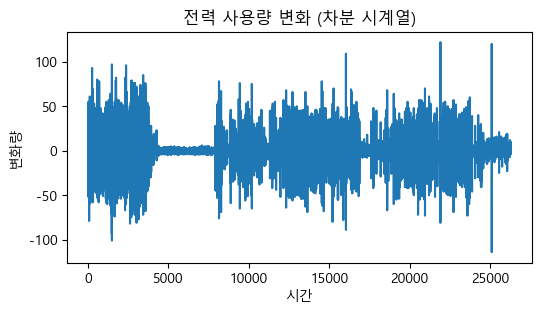

In [49]:
# Ï†ÑÎ†• ÏÇ¨Ïö©ÎüâÏùò Î≥ÄÌôîÎ•º ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú ÌôïÏù∏Ìï¥Î¥ÖÏãúÎã§ !
# Îç∞Ïù¥ÌÑ∞Îäî Ï∞®Î∂Ñ(diff)ÎêòÏñ¥ ÏûàÏñ¥ÏÑú, Ïã§Ï†ú Ï†ÑÎ†• ÏÇ¨Ïö©ÎüâÏù¥ ÏïÑÎãå Î≥ÄÌôîÎüâÏùÑ Í∞ÄÎ¶¨ÌÇµÎãàÎã§.
plt.plot(elec['V1'])
plt.title("Ï†ÑÎ†• ÏÇ¨Ïö©Îüâ Î≥ÄÌôî (Ï∞®Î∂Ñ ÏãúÍ≥ÑÏó¥)")
plt.xlabel("ÏãúÍ∞Ñ")
plt.ylabel("Î≥ÄÌôîÎüâ")
plt.show()

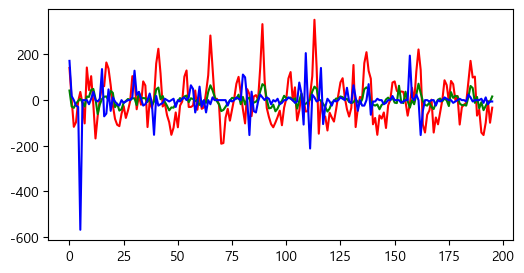

In [51]:
plt.plot(elec.V4[:196], color='r')
plt.plot(elec.V14[:196], color='g')
plt.plot(elec.V114[:196], color='b')
plt.show()

## Dataset ÌÅ¥ÎûòÏä§ Ï†ïÏùò

In [53]:
# PyTorchÏóêÏÑúÎäî Dataset ÌÅ¥ÎûòÏä§Î•º ÎßåÎì§Ïñ¥ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Î•º Í¥ÄÎ¶¨Ìï©ÎãàÎã§.
# ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞Î•º ÏùºÏ†ï Í∏∏Ïù¥(WIN)ÎßåÌÅº Ïä¨ÎùºÏù¥Îî© ÏúàÎèÑÏö∞ Î∞©ÏãùÏúºÎ°ú ÏûòÎùºÏÑú
# ÏûÖÎ†•(X)Í≥º ÏòàÏ∏° ÎåÄÏÉÅ(Y)ÏùÑ ÎßåÎì≠ÎãàÎã§.

from torch.utils.data import Dataset
import torch

# Îî•Îü¨Îãù ÏÑ∏ÏÖò Î≥µÏäµ ! ***ÏóêÎäî Î≠êÍ∞Ä Îì§Ïñ¥Í∞ÄÏïº Ìï†ÍπåÏöî?
class ElectricityDataset(Dataset):
    def __init__(self, data, win, horizon):
        """
        Args:
            series (np.array): ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞.
            win (int): ÏûÖÎ†• ÏãúÍ≥ÑÏó¥ Í∏∏Ïù¥ (Ïòà: 24)
            horizon (int): ÏòàÏ∏° ÏãúÍ≥ÑÏó¥ Í∏∏Ïù¥ (Ïòà: 3)
        """
        super(ElectricityDataset, self).__init__()
        self.series = data
        self.win = win
        self.horizon = horizon

        # Ï¥ù Îç∞Ïù¥ÌÑ∞ Í∏∏Ïù¥(T)
        self.T = data.shape[0]
        # slide Í∞ÄÎä•Ìïú ÏÉòÌîå Í∞úÏàò
        self.n_samples = self.T - self.win - self.horizon + 1

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        start = idx
        end_x = idx + self.win
        end_y = idx + self.win + self.horizon

        X = self.series[start : end_x]
        y = self.series[end_x : end_y, 0]

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return X, y

## Îç∞Ïù¥ÌÑ∞ÏÖã ÎÇòÎàÑÍ∏∞

In [55]:
from torch.utils.data import Dataset, DataLoader

# Îã§Ï∞®Ïõê ÏûÖÎ†•ÎèÑ Í∞ÄÎä•ÌïòÏßÄÎßå Ïù¥Î≤àÏóêÎäî Îã®Ïùº Î≥ÄÏàòÎßå ÏÇ¨Ïö©ÌïòÍ≤†ÏäµÎãàÎã§ !
# Ï†ÑÎ†• ÏÇ¨Ïö©Îüâ Îç∞Ïù¥ÌÑ∞Ïùò Ï≤´ Î≤àÏß∏ Ïó¥(V1)ÏùÑ ÏÑ†ÌÉùÌï¥Ï£ºÏÑ∏Ïöî.
data = elec[['V1']].values

n_total = len(data)
n_train = int(n_total * DATA_SEGMENTS['tr'])
n_val = int(n_total * DATA_SEGMENTS['va'])

train_series = data[:n_train]
val_series = data[n_train: n_train + n_val]
test_series = data[n_train + n_val:]

# Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±
train_dataset = ElectricityDataset(train_series, WIN, H)
val_dataset = ElectricityDataset(val_series, WIN, H)
test_dataset = ElectricityDataset(test_series, WIN, H)

# Îç∞Ïù¥ÌÑ∞Î•º Í≥µÍ∏âÌï† DataLoader (Î∞∞Ïπò Îã®ÏúÑÎ°ú)
train_loader = DataLoader(train_dataset, batch_size=BATCH_N, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_N)
test_loader = DataLoader(test_dataset, batch_size=BATCH_N)

Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Î∞∞ÏπòÎ°ú ÎÇòÎà† Î™®Îç∏Ïóê Î∞îÎ°ú Ïì∏ Ïàò ÏûàÎèÑÎ°ù Ï§ÄÎπÑÎ•º ÎßàÏ≥§ÏäµÎãàÎã§.

## Î™®Îç∏ Ï†ïÏùò

- **ÏûÖÎ†•**: Í≥ºÍ±∞ `WIN` ÏãúÍ∞Ñ ÎèôÏïàÏùò ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞  
- **Ï∂úÎ†•**: ÎØ∏Îûò `H`ÏãúÍ∞ÑÏùò ÏãúÍ≥ÑÏó¥ ÏòàÏ∏°Í∞í
- **Íµ¨Ï°∞**:
  - LSTM Í≥ÑÏ∏µ: ÏãúÍ≥ÑÏó¥Ïùò Ìå®ÌÑ¥ÏùÑ Í∏∞ÏñµÌïòÍ≥† Ï∂îÎ°†
  - FC Í≥ÑÏ∏µ: ÎßàÏßÄÎßâ hidden stateÎ•º Í∏∞Î∞òÏúºÎ°ú Îã§Ïàò ÏãúÏ†ê ÏòàÏ∏°
- **Dropout**: ÌïôÏäµ Ï§ë Í≥ºÏ†ÅÌï© Î∞©ÏßÄÏö©

Ïù¥ Î™®Îç∏ÏùÄ ÏûÖÎ†• ÏãúÍ≥ÑÏó¥Ïùò Ìå®ÌÑ¥ÏùÑ LSTMÏúºÎ°ú ÌïôÏäµÌïòÍ≥†,
ÎßàÏßÄÎßâ ÏãúÏ†êÏùò Ï†ïÎ≥¥Î•º ÌôúÏö©Ìï¥ ÎØ∏ÎûòÏùò ÌùêÎ¶ÑÏùÑ ÏòàÏ∏°Ìï©ÎãàÎã§.

In [57]:
# ÏãúÍ≥ÑÏó¥ ÏûÖÎ†•ÏùÑ Î∞õÏïÑ, RNNÏúºÎ°ú ÎÇ¥Î∂Ä ÏÉÅÌÉúÎ•º ÏóÖÎç∞Ïù¥Ìä∏ÌïòÍ≥†,
# ÎßàÏßÄÎßâ hidden stateÎ•º Í∏∞Î∞òÏúºÎ°ú ÎØ∏Îûò HÏãúÍ∞ÑÏùò Í∞íÏùÑ ÏòàÏ∏°Ìï©ÎãàÎã§.

class RNNForecastModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_horizon, dropout=0.2):
        super(RNNForecastModel, self).__init__()
        self.hidden_size = hidden_size
        self.output_horizon = output_horizon

        # LSTM Î†àÏù¥Ïñ¥ Ï†ÅÏö©
        self.rnn = nn.LSTM(input_size=input_size,
                           hidden_size=hidden_size,
                           batch_first=True,
                           dropout=dropout)

        # RNN Ï∂úÎ†•ÏóêÏÑú HÍ∞úÏùò ÏãúÏ†ê ÏòàÏ∏°
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_horizon)
        )

    def forward(self, x):
        out, _ = self.rnn(x)

        # ÎßàÏßÄÎßâ ÏãúÏ†êÏùò hidden stateÎßå ÏÇ¨Ïö©
        last_hidden = out[:, -1, :]

        # ÎØ∏Îûò horizon Í∞í ÏòàÏ∏°
        y_pred = self.fc(last_hidden)
        return y_pred

In [59]:
# ÌïôÏäµÏóê ÏÇ¨Ïö©Ìï† Î™®Îç∏ÏùÑ ÏÉùÏÑ±Ìï©ÎãàÎã§.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RNNForecastModel(input_size=data.shape[1],
                         hidden_size=RNN_UNITS,
                         output_horizon=H,
                         dropout=DROP).to(device)

In [61]:
# ÏÜêÏã§Ìï®Ïàò: ÌèâÍ∑† Ï†úÍ≥± Ïò§Ï∞® (MSE)
criterion = nn.MSELoss()

# ÏòµÌã∞ÎßàÏù¥Ï†Ä: Adam
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## ÌïôÏäµ

### Î™®Îç∏ ÌïôÏäµ Í≥ºÏ†ï ÏöîÏïΩ

- **Train** Îã®Í≥Ñ:
  - Î™®Îç∏Ïù¥ ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Î•º ÌÜµÌï¥ ÏòàÏ∏°Í∞í ÏÉùÏÑ±
  - ÏÜêÏã§Ìï®ÏàòÎ°ú Ïã§Ï†úÍ∞íÍ≥º Ï∞®Ïù¥Î•º Í≥ÑÏÇ∞
  - Ïù¥ Ï∞®Ïù¥Î•º Ï§ÑÏù¥Í∏∞ ÏúÑÌï¥ Î™®Îç∏Ïùò Í∞ÄÏ§ëÏπòÎ•º ÏóÖÎç∞Ïù¥Ìä∏

- **Validation** Îã®Í≥Ñ:
  - Î™®Îç∏Ïù¥ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Ïô∏Ïùò Îç∞Ïù¥ÌÑ∞ÏóêÏÑúÎèÑ Ïûò ÏûëÎèôÌïòÎäîÏßÄ ÌôïÏù∏
  - ÏÑ±Îä•Ïù¥ Í∞úÏÑ†ÎêòÏßÄ ÏïäÏúºÎ©¥ ÌïôÏäµÏùÑ Ï°∞Í∏∞ Ï¢ÖÎ£å

In [63]:
def evaluate(model, data_loader):
    """ Í≤ÄÏ¶ù ÎòêÎäî ÌÖåÏä§Ìä∏ Ïãú ÏÑ±Îä• ÌèâÍ∞Ä """
    model.eval() # Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ï (eval)
    total_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in data_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            pred = model(X_batch)
            loss = criterion(pred, Y_batch)
            total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(data_loader.dataset)

In [65]:
# ÌïôÏäµ Î£®ÌîÑ ÏãúÏûë
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(N_EPOCHS):
    model.train() # Î™®Îç∏ÏùÑ ÌïôÏäµ Î™®ÎìúÎ°ú ÏÑ§Ï†ï (train)
    running_loss = 0.0

    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        # ÏàúÏ†ÑÌåå
        pred = model(X_batch)
        loss = criterion(pred, Y_batch)

        # Ïó≠Ï†ÑÌåå + ÏµúÏ†ÅÌôî
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    # ÌèâÍ∑† ÌïôÏäµ ÏÜêÏã§
    train_loss = running_loss / len(train_loader.dataset)
    
    # Í≤ÄÏ¶ù ÏÜêÏã§
    val_loss = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}/{N_EPOCHS} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    # Ï°∞Í∏∞ Ï¢ÖÎ£å Ï°∞Í±¥ ÌôïÏù∏
    if best_val_loss - val_loss < COR_THRESHOLD:
        epochs_no_improve += 1
        if epochs_no_improve >= THRESHOLD_EPOCHS:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    else:
        best_val_loss = val_loss
        epochs_no_improve = 0

Epoch 1/30 - Train Loss: 188.056533, Val Loss: 101.948167
Epoch 2/30 - Train Loss: 187.649256, Val Loss: 101.671000
Epoch 3/30 - Train Loss: 187.191678, Val Loss: 101.368926
Epoch 4/30 - Train Loss: 186.709910, Val Loss: 101.034933
Epoch 5/30 - Train Loss: 186.136390, Val Loss: 100.641563
Epoch 6/30 - Train Loss: 185.391084, Val Loss: 100.179742
Epoch 7/30 - Train Loss: 184.573673, Val Loss: 99.622626
Epoch 8/30 - Train Loss: 183.395672, Val Loss: 98.907996
Epoch 9/30 - Train Loss: 181.970679, Val Loss: 97.948361
Epoch 10/30 - Train Loss: 179.717382, Val Loss: 96.636638
Epoch 11/30 - Train Loss: 177.092192, Val Loss: 95.274624
Epoch 12/30 - Train Loss: 175.149186, Val Loss: 94.534028
Epoch 13/30 - Train Loss: 173.344276, Val Loss: 93.191149
Epoch 14/30 - Train Loss: 171.451457, Val Loss: 91.885426
Epoch 15/30 - Train Loss: 169.466866, Val Loss: 90.663755
Epoch 16/30 - Train Loss: 167.475594, Val Loss: 89.732497
Epoch 17/30 - Train Loss: 165.588284, Val Loss: 88.809300
Epoch 18/30 - Tra

## ÏòàÏ∏° Î∞è ÏÑ±Îä• ÌèâÍ∞Ä

In [67]:
# Ï†ÑÏ≤¥ ÌÖåÏä§Ìä∏ÏÖãÏóê ÎåÄÌï¥ ÏòàÏ∏°Í∞íÍ≥º Ïã§Ï†úÍ∞íÏùÑ Ï†ÄÏû•
model.eval() # Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ï

y_preds = []
y_trues = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        pred = model(X_batch)

        y_preds.append(pred.cpu().numpy()) # y_predsÏóê Í∞í Ï∂îÍ∞Ä (append)
        y_trues.append(Y_batch.cpu().numpy()) # y_truesÏóê Í∞í Ï∂îÍ∞Ä

# Î¶¨Ïä§Ìä∏Î•º numpy Î∞∞Ïó¥Î°ú Í≤∞Ìï©
y_preds = np.concatenate(y_preds, axis=0)
y_trues = np.concatenate(y_trues, axis=0)

In [69]:
# Ï†ÑÏ≤¥ ÏãúÍ≥ÑÏó¥ Í∏∞Ï§ÄÏúºÎ°ú flatten (H=3Ïù∏ Í≤ΩÏö∞ Í∞Å ÏÉòÌîåÎãπ 3Í∞úÏùò ÏòàÏ∏°)
y_preds_flat = y_preds.flatten()
y_trues_flat = y_trues.flatten()

In [71]:
# ÌîºÏñ¥Ïä® ÏÉÅÍ¥ÄÍ≥ÑÏàò
pearson_corr, _ = pearsonr(y_trues_flat, y_preds_flat)

# Ïä§ÌîºÏñ¥Îßå ÏÉÅÍ¥ÄÍ≥ÑÏàò
spearman_corr, _ = spearmanr(y_trues_flat, y_preds_flat)

print(f"Pearson Correlation:  {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

Pearson Correlation:  0.4163
Spearman Correlation: 0.2968


In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse**0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2 Score": r2
    }

In [75]:
compute_metrics(y_trues_flat, y_preds_flat)

{'MSE': 79.5430679321289,
 'RMSE': 8.918692052769224,
 'MAE': 4.317430019378662,
 'R2 Score': 0.1713976263999939}

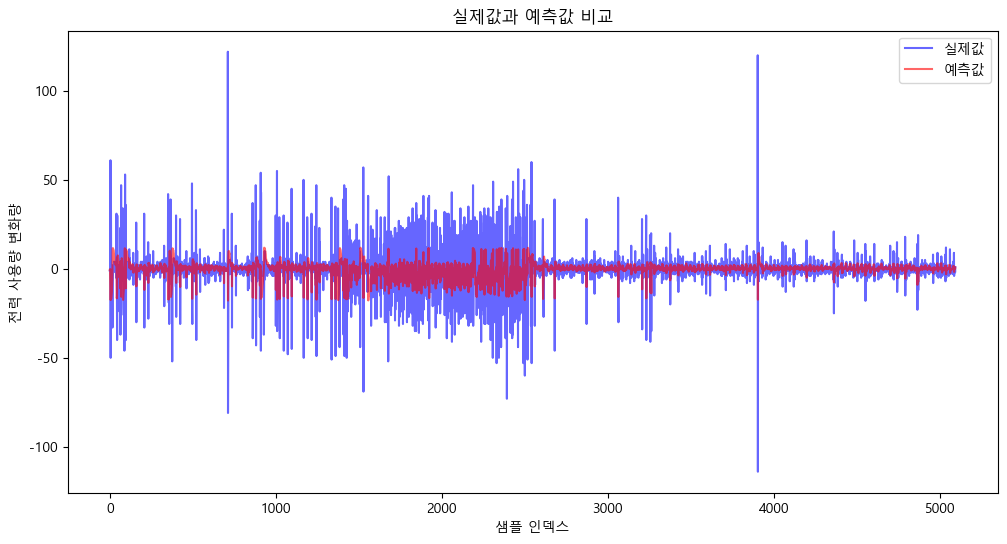

In [77]:
# y_truesÏôÄ y_predsÎ•º ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú ÎπÑÍµê
plt.figure(figsize=(12, 6))
plt.plot(y_trues_flat, label='Ïã§Ï†úÍ∞í', color='blue', alpha=0.6)
plt.plot(y_preds_flat, label='ÏòàÏ∏°Í∞í', color='red', alpha=0.6)
plt.title('Ïã§Ï†úÍ∞íÍ≥º ÏòàÏ∏°Í∞í ÎπÑÍµê')
plt.xlabel('ÏÉòÌîå Ïù∏Îç±Ïä§')
plt.ylabel('Ï†ÑÎ†• ÏÇ¨Ïö©Îüâ Î≥ÄÌôîÎüâ')
plt.legend()
plt.show()

ÏßÅÏ†ë ÌïôÏäµÏùÑ ÏãúÏº∞Í∏∞ ÎïåÎ¨∏Ïóê Î™®Îç∏ ÏÑ±Îä•ÏùÄ Ï¢ãÏßÄ ÏïäÏßÄÎßå(ü•≤), Ïù¥Îü∞ ÌîÑÎ°úÏÑ∏Ïä§Î°ú Îî•Îü¨Îãù Î™®Îç∏ÏùÑ ÏãúÍ≥ÑÏó¥ ÏòàÏ∏°Ïóê Ï†ÅÏö©Ìï† Ïàò ÏûàÎã§Îäî Í≤ÉÏùÑ ÌôïÏù∏Ìï¥ Î≥º Ïàò ÏûàÍ≤†ÏäµÎãàÎã§ üòä

ÎßàÏßÄÎßâ Í≥ºÏ†úÍπåÏßÄ ÎÑàÎ¨¥ ÏàòÍ≥†ÌïòÏÖ®ÏäµÎãàÎã§ !!